In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000



 1/64 [..............................] - ETA: 1:47 - loss: 0.0239 - STD: 1.4684e-04 - MAE: 0.1375


 3/64 [>.............................] - ETA: 1s - loss: 0.0186 - STD: 2.7471e-04 - MAE: 0.1074  


 5/64 [=>............................] - ETA: 1s - loss: 0.0195 - STD: 2.6720e-04 - MAE: 0.1085


 7/64 [==>...........................] - ETA: 1s - loss: 0.0184 - STD: 2.7438e-04 - MAE: 0.1034


 9/64 [===>..........................] - ETA: 1s - loss: 0.0166 - STD: 3.0597e-04 - MAE: 0.0977


11/64 [====>.........................] - ETA: 1s - loss: 0.0159 - STD: 3.4992e-04 - MAE: 0.0977


13/64 [=====>........................] - ETA: 1s - loss: 0.0154 - STD: 3.9004e-04 - MAE: 0.0972


15/64 [======>.......................] - ETA: 3s - loss: 0.0150 - STD: 4.1774e-04 - MAE: 0.0948


18/64 [=======>......................] - ETA: 2s - loss: 0.0142 - STD: 4.4719e-04 - MAE: 0.0917


20/64 [========>.....................] - ETA: 2s - loss: 0.0139 - STD: 4.6599e-04 - MAE: 0.0902


22/64 [=========>....................] - ETA: 2s - loss: 0.0136 - STD: 4.9130e-04 - MAE: 0.0889


25/64 [==========>...................] - ETA: 2s - loss: 0.0132 - STD: 5.4127e-04 - MAE: 0.0879


27/64 [===========>..................] - ETA: 1s - loss: 0.0130 - STD: 5.7922e-04 - MAE: 0.0877


29/64 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 6.1556e-04 - MAE: 0.0873


32/64 [==============>...............] - ETA: 1s - loss: 0.0125 - STD: 6.6354e-04 - MAE: 0.0864


34/64 [==============>...............] - ETA: 1s - loss: 0.0123 - STD: 6.9496e-04 - MAE: 0.0857


36/64 [===============>..............] - ETA: 1s - loss: 0.0122 - STD: 7.2897e-04 - MAE: 0.0851


38/64 [================>.............] - ETA: 1s - loss: 0.0121 - STD: 7.6910e-04 - MAE: 0.0847


40/64 [=================>............] - ETA: 1s - loss: 0.0120 - STD: 8.1506e-04 - MAE: 0.0844


42/64 [==================>...........] - ETA: 0s - loss: 0.0119 - STD: 8.6678e-04 - MAE: 0.0842


44/64 [===================>..........] - ETA: 0s - loss: 0.0118 - STD: 9.2189e-04 - MAE: 0.0840


46/64 [====================>.........] - ETA: 0s - loss: 0.0117 - STD: 9.7856e-04 - MAE: 0.0837


48/64 [=====================>........] - ETA: 0s - loss: 0.0116 - STD: 0.0010 - MAE: 0.0834    


50/64 [======================>.......] - ETA: 0s - loss: 0.0115 - STD: 0.0011 - MAE: 0.0831


52/64 [=======================>......] - ETA: 0s - loss: 0.0115 - STD: 0.0012 - MAE: 0.0828


54/64 [========================>.....] - ETA: 0s - loss: 0.0114 - STD: 0.0013 - MAE: 0.0826


56/64 [=========================>....] - ETA: 0s - loss: 0.0113 - STD: 0.0014 - MAE: 0.0825


58/64 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 0.0015 - MAE: 0.0823


60/64 [===========================>..] - ETA: 0s - loss: 0.0112 - STD: 0.0016 - MAE: 0.0821


62/64 [============================>.] - ETA: 0s - loss: 0.0111 - STD: 0.0017 - MAE: 0.0819


64/64 [==============================] - ETA: 0s - loss: 0.0111 - STD: 0.0019 - MAE: 0.0817


64/64 [==============================] - 5s 50ms/step - loss: 0.0111 - STD: 0.0019 - MAE: 0.0817 - val_loss: 0.0089 - val_STD: 0.0052 - val_MAE: 0.0744


Epoch 2/10000



 1/64 [..............................] - ETA: 4s - loss: 0.0093 - STD: 0.0071 - MAE: 0.0761


 3/64 [>.............................] - ETA: 1s - loss: 0.0093 - STD: 0.0077 - MAE: 0.0761


 5/64 [=>............................] - ETA: 1s - loss: 0.0093 - STD: 0.0084 - MAE: 0.0764


 7/64 [==>...........................] - ETA: 1s - loss: 0.0093 - STD: 0.0091 - MAE: 0.0763


 9/64 [===>..........................] - ETA: 1s - loss: 0.0093 - STD: 0.0098 - MAE: 0.0762


11/64 [====>.........................] - ETA: 1s - loss: 0.0092 - STD: 0.0106 - MAE: 0.0759


13/64 [=====>........................] - ETA: 1s - loss: 0.0091 - STD: 0.0115 - MAE: 0.0755


15/64 [======>.......................] - ETA: 1s - loss: 0.0091 - STD: 0.0125 - MAE: 0.0753


18/64 [=======>......................] - ETA: 1s - loss: 0.0090 - STD: 0.0142 - MAE: 0.0748


20/64 [========>.....................] - ETA: 1s - loss: 0.0090 - STD: 0.0154 - MAE: 0.0746


22/64 [=========>....................] - ETA: 1s - loss: 0.0089 - STD: 0.0167 - MAE: 0.0744


24/64 [==========>...................] - ETA: 1s - loss: 0.0088 - STD: 0.0180 - MAE: 0.0742


26/64 [===========>..................] - ETA: 1s - loss: 0.0088 - STD: 0.0193 - MAE: 0.0740


28/64 [============>.................] - ETA: 0s - loss: 0.0088 - STD: 0.0205 - MAE: 0.0738


30/64 [=============>................] - ETA: 0s - loss: 0.0087 - STD: 0.0217 - MAE: 0.0736


32/64 [==============>...............] - ETA: 0s - loss: 0.0087 - STD: 0.0227 - MAE: 0.0733


34/64 [==============>...............] - ETA: 0s - loss: 0.0086 - STD: 0.0237 - MAE: 0.0731


36/64 [===============>..............] - ETA: 0s - loss: 0.0086 - STD: 0.0245 - MAE: 0.0730


38/64 [================>.............] - ETA: 0s - loss: 0.0085 - STD: 0.0253 - MAE: 0.0728


40/64 [=================>............] - ETA: 0s - loss: 0.0085 - STD: 0.0259 - MAE: 0.0726


42/64 [==================>...........] - ETA: 0s - loss: 0.0085 - STD: 0.0265 - MAE: 0.0724


44/64 [===================>..........] - ETA: 0s - loss: 0.0085 - STD: 0.0271 - MAE: 0.0723


46/64 [====================>.........] - ETA: 0s - loss: 0.0084 - STD: 0.0276 - MAE: 0.0721


48/64 [=====================>........] - ETA: 0s - loss: 0.0084 - STD: 0.0282 - MAE: 0.0720


50/64 [======================>.......] - ETA: 0s - loss: 0.0084 - STD: 0.0287 - MAE: 0.0718


52/64 [=======================>......] - ETA: 0s - loss: 0.0084 - STD: 0.0292 - MAE: 0.0717


55/64 [========================>.....] - ETA: 0s - loss: 0.0083 - STD: 0.0300 - MAE: 0.0715


57/64 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.0304 - MAE: 0.0714


59/64 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.0309 - MAE: 0.0712


61/64 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.0313 - MAE: 0.0711


63/64 [============================>.] - ETA: 0s - loss: 0.0082 - STD: 0.0316 - MAE: 0.0710


64/64 [==============================] - 2s 31ms/step - loss: 0.0082 - STD: 0.0318 - MAE: 0.0709 - val_loss: 0.0069 - val_STD: 0.0307 - val_MAE: 0.0645


Epoch 3/10000



 1/64 [..............................] - ETA: 4s - loss: 0.0076 - STD: 0.0432 - MAE: 0.0671


 3/64 [>.............................] - ETA: 1s - loss: 0.0074 - STD: 0.0435 - MAE: 0.0662


 5/64 [=>............................] - ETA: 1s - loss: 0.0074 - STD: 0.0435 - MAE: 0.0660


 7/64 [==>...........................] - ETA: 1s - loss: 0.0074 - STD: 0.0440 - MAE: 0.0661


 9/64 [===>..........................] - ETA: 1s - loss: 0.0074 - STD: 0.0444 - MAE: 0.0659


11/64 [====>.........................] - ETA: 1s - loss: 0.0073 - STD: 0.0446 - MAE: 0.0656


14/64 [=====>........................] - ETA: 1s - loss: 0.0072 - STD: 0.0450 - MAE: 0.0653


16/64 [======>.......................] - ETA: 1s - loss: 0.0072 - STD: 0.0452 - MAE: 0.0650


18/64 [=======>......................] - ETA: 1s - loss: 0.0071 - STD: 0.0454 - MAE: 0.0645


21/64 [========>.....................] - ETA: 1s - loss: 0.0070 - STD: 0.0459 - MAE: 0.0641


23/64 [=========>....................] - ETA: 1s - loss: 0.0069 - STD: 0.0464 - MAE: 0.0637


25/64 [==========>...................] - ETA: 1s - loss: 0.0069 - STD: 0.0471 - MAE: 0.0635


27/64 [===========>..................] - ETA: 0s - loss: 0.0069 - STD: 0.0478 - MAE: 0.0632


30/64 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0491 - MAE: 0.0631


32/64 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0499 - MAE: 0.0628


34/64 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.0505 - MAE: 0.0625


36/64 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0512 - MAE: 0.0623


38/64 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0518 - MAE: 0.0622


40/64 [=================>............] - ETA: 0s - loss: 0.0066 - STD: 0.0522 - MAE: 0.0620


42/64 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0526 - MAE: 0.0618


44/64 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0530 - MAE: 0.0616


46/64 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0534 - MAE: 0.0614


48/64 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0536 - MAE: 0.0613


50/64 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0539 - MAE: 0.0611


52/64 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0542 - MAE: 0.0610


54/64 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0545 - MAE: 0.0608


56/64 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0547 - MAE: 0.0607


58/64 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0549 - MAE: 0.0605


60/64 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0552 - MAE: 0.0604


62/64 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0554 - MAE: 0.0602


64/64 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0556 - MAE: 0.0602


64/64 [==============================] - 2s 31ms/step - loss: 0.0063 - STD: 0.0556 - MAE: 0.0602 - val_loss: 0.0052 - val_STD: 0.0521 - val_MAE: 0.0553


Epoch 4/10000



 1/64 [..............................] - ETA: 4s - loss: 0.0055 - STD: 0.0623 - MAE: 0.0552


 3/64 [>.............................] - ETA: 1s - loss: 0.0056 - STD: 0.0626 - MAE: 0.0557


 5/64 [=>............................] - ETA: 1s - loss: 0.0057 - STD: 0.0628 - MAE: 0.0562


 7/64 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0637 - MAE: 0.0563


 9/64 [===>..........................] - ETA: 1s - loss: 0.0056 - STD: 0.0637 - MAE: 0.0564


11/64 [====>.........................] - ETA: 1s - loss: 0.0056 - STD: 0.0634 - MAE: 0.0562


13/64 [=====>........................] - ETA: 1s - loss: 0.0056 - STD: 0.0632 - MAE: 0.0562


16/64 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0630 - MAE: 0.0563


18/64 [=======>......................] - ETA: 1s - loss: 0.0057 - STD: 0.0634 - MAE: 0.0564


20/64 [========>.....................] - ETA: 1s - loss: 0.0057 - STD: 0.0629 - MAE: 0.0564


22/64 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0568


24/64 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0573


26/64 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0571


29/64 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0574


31/64 [=============>................] - ETA: 0s - loss: 0.0059 - STD: 0.0620 - MAE: 0.0574


33/64 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0619 - MAE: 0.0574


35/64 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0616 - MAE: 0.0573


37/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0616 - MAE: 0.0573


39/64 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0614 - MAE: 0.0572


41/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0614 - MAE: 0.0572


43/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0613 - MAE: 0.0571


45/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0614 - MAE: 0.0571


47/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0613 - MAE: 0.0569


50/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0615 - MAE: 0.0568


52/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0616 - MAE: 0.0567


54/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0617 - MAE: 0.0566


56/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0619 - MAE: 0.0566


58/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0620 - MAE: 0.0565


60/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0622 - MAE: 0.0564


62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0623 - MAE: 0.0563


64/64 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0625 - MAE: 0.0562


64/64 [==============================] - 2s 30ms/step - loss: 0.0056 - STD: 0.0625 - MAE: 0.0562 - val_loss: 0.0049 - val_STD: 0.0577 - val_MAE: 0.0533


Epoch 5/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0527


 3/64 [>.............................] - ETA: 1s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0532


 5/64 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0532


 7/64 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0533


 9/64 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0533


12/64 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0531


14/64 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0532


16/64 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0531


18/64 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0532


20/64 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0533


22/64 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0532


25/64 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0532


28/64 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0531


30/64 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0531


33/64 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0530


36/64 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0530


39/64 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0529


42/64 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0529


45/64 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0528


48/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0529


51/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0528


54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0528


57/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0528


60/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0528


63/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0527


64/64 [==============================] - 2s 28ms/step - loss: 0.0050 - STD: 0.0683 - MAE: 0.0527 - val_loss: 0.0046 - val_STD: 0.0594 - val_MAE: 0.0511


Epoch 6/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0674 - MAE: 0.0513


 3/64 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0513


 6/64 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0518


 9/64 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0527


12/64 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0691 - MAE: 0.0530


15/64 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0685 - MAE: 0.0531


18/64 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0530


21/64 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0529


24/64 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0528


27/64 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0527


30/64 [=============>................] - ETA: 0s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0526


33/64 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0525


36/64 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0524


39/64 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0523


42/64 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0522


45/64 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0522


48/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0521


51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0520


53/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0521


56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0521


59/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0521


62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0521


64/64 [==============================] - 2s 27ms/step - loss: 0.0049 - STD: 0.0694 - MAE: 0.0521 - val_loss: 0.0050 - val_STD: 0.0553 - val_MAE: 0.0517


Epoch 7/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0519


 3/64 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0523


 5/64 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0526


 8/64 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523


11/64 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0528


14/64 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0531


17/64 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0532


20/64 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0685 - MAE: 0.0533


23/64 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0684 - MAE: 0.0538


26/64 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0676 - MAE: 0.0549


29/64 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0548


31/64 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0550


34/64 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0552


37/64 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0550


40/64 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0650 - MAE: 0.0551


42/64 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0650 - MAE: 0.0550


45/64 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0647 - MAE: 0.0549


48/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0648 - MAE: 0.0548


51/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0649 - MAE: 0.0547


54/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0545


57/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0650 - MAE: 0.0544


60/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0543


63/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0654 - MAE: 0.0541


64/64 [==============================] - 2s 27ms/step - loss: 0.0053 - STD: 0.0655 - MAE: 0.0541 - val_loss: 0.0048 - val_STD: 0.0578 - val_MAE: 0.0509


Epoch 8/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0647 - MAE: 0.0506


 4/64 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0514


 7/64 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0514


10/64 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0512


13/64 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0510


16/64 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0510


19/64 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0510


22/64 [=========>....................] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0510


25/64 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0510


28/64 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0509


31/64 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0508


34/64 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0508


37/64 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0508


40/64 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0508


43/64 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0508


46/64 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0508


49/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0508


52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0507


55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0507


57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0507


60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0506


63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0506


64/64 [==============================] - 2s 27ms/step - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506 - val_loss: 0.0043 - val_STD: 0.0637 - val_MAE: 0.0493


Epoch 9/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0501


 4/64 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499


 7/64 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499


10/64 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0497


13/64 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0497


16/64 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498


19/64 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499


22/64 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499


25/64 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498


28/64 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0498


31/64 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0498


33/64 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498


36/64 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498


39/64 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0498


42/64 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498


45/64 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498


48/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498


51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0498


54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0498


57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0498


59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0498


62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498


64/64 [==============================] - 2s 27ms/step - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498 - val_loss: 0.0042 - val_STD: 0.0654 - val_MAE: 0.0487


Epoch 10/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0482


 4/64 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0493


 7/64 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0494


10/64 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0495


13/64 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0494


16/64 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494


19/64 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493


22/64 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0494


25/64 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0494


28/64 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493


31/64 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0498


34/64 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0499


37/64 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0500


40/64 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500


43/64 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499


46/64 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0500


49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0500


52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0500


55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499


58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499


60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499


63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0500


64/64 [==============================] - 2s 27ms/step - loss: 0.0045 - STD: 0.0725 - MAE: 0.0500 - val_loss: 0.0041 - val_STD: 0.0685 - val_MAE: 0.0496


Epoch 11/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0774 - MAE: 0.0513


 4/64 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0748 - MAE: 0.0501


 7/64 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0496


10/64 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495


12/64 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494


15/64 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0493


18/64 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494


21/64 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494


24/64 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0493


27/64 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0493


30/64 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0493


33/64 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494


36/64 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0493


38/64 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494


41/64 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0493


44/64 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0493


47/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492


49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492


52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492


55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0493


58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0493


60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0493


63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0493


64/64 [==============================] - 2s 27ms/step - loss: 0.0044 - STD: 0.0734 - MAE: 0.0493 - val_loss: 0.0041 - val_STD: 0.0680 - val_MAE: 0.0492


Epoch 12/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0768 - MAE: 0.0498


 4/64 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0500


 7/64 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0501


10/64 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0496


13/64 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495


15/64 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496


18/64 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494


21/64 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496


24/64 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495


26/64 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495


29/64 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495


32/64 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495


35/64 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0495


38/64 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0495


41/64 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0495


44/64 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495


47/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494


50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0494


52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494


55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493


58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0494


61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495


63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497


64/64 [==============================] - 2s 27ms/step - loss: 0.0045 - STD: 0.0730 - MAE: 0.0496 - val_loss: 0.0040 - val_STD: 0.0632 - val_MAE: 0.0477


Epoch 13/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478


 4/64 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0488


 7/64 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0491


10/64 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0487


13/64 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0486


16/64 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0486


19/64 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0486


22/64 [=========>....................] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0487


25/64 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488


27/64 [===========>..................] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489


30/64 [=============>................] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489


33/64 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490


36/64 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489


39/64 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489


42/64 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489


45/64 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489


48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490


51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489


54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489


57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488


63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


64/64 [==============================] - 2s 27ms/step - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489 - val_loss: 0.0043 - val_STD: 0.0612 - val_MAE: 0.0479


Epoch 14/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0473


 3/64 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0492


 6/64 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0501


 9/64 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0502


12/64 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0502


15/64 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500


18/64 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0498


21/64 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0496


24/64 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0494


27/64 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494


30/64 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493


33/64 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0492


36/64 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492


39/64 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0490


42/64 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490


45/64 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489


56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489


59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488


62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488


64/64 [==============================] - 2s 27ms/step - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488 - val_loss: 0.0042 - val_STD: 0.0615 - val_MAE: 0.0475


Epoch 15/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0474


 4/64 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0720 - MAE: 0.0483


 7/64 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0496


10/64 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0495


13/64 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0497


16/64 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0496


19/64 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0494


22/64 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0492


25/64 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0490


28/64 [============>.................] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489


30/64 [=============>................] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489


33/64 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488


36/64 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487


39/64 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487


42/64 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0486


44/64 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0486


47/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486


50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485


53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485


55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485


58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485


61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485


64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484


64/64 [==============================] - 2s 27ms/step - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484 - val_loss: 0.0040 - val_STD: 0.0628 - val_MAE: 0.0468


Epoch 16/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0476


 4/64 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481


 7/64 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0481


10/64 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483


13/64 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481


16/64 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480


19/64 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0478


22/64 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0477


25/64 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0478


28/64 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479


31/64 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479


34/64 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479


36/64 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479


39/64 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478


42/64 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478


45/64 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479


47/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478


50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480


53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0481


56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482


59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0482


62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0482


64/64 [==============================] - 2s 27ms/step - loss: 0.0042 - STD: 0.0746 - MAE: 0.0482 - val_loss: 0.0039 - val_STD: 0.0634 - val_MAE: 0.0467


Epoch 17/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0478


 4/64 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0490


 7/64 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0487


10/64 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0485


13/64 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487


16/64 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487


19/64 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0486


22/64 [=========>....................] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0485


24/64 [==========>...................] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0484


27/64 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0483


30/64 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482


33/64 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481


35/64 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480


37/64 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480


40/64 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479


43/64 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479


46/64 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479


48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479


51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479


54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479


57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480


60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481


62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482


64/64 [==============================] - 2s 27ms/step - loss: 0.0042 - STD: 0.0746 - MAE: 0.0483 - val_loss: 0.0069 - val_STD: 0.0470 - val_MAE: 0.0601


Epoch 18/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0068 - STD: 0.0539 - MAE: 0.0589


 4/64 [>.............................] - ETA: 1s - loss: 0.0075 - STD: 0.0642 - MAE: 0.0645


 7/64 [==>...........................] - ETA: 1s - loss: 0.0083 - STD: 0.0653 - MAE: 0.0697


10/64 [===>..........................] - ETA: 1s - loss: 0.0100 - STD: 0.0535 - MAE: 0.0755


13/64 [=====>........................] - ETA: 1s - loss: 0.0098 - STD: 0.0532 - MAE: 0.0761


16/64 [======>.......................] - ETA: 1s - loss: 0.0097 - STD: 0.0485 - MAE: 0.0741


19/64 [=======>......................] - ETA: 1s - loss: 0.0093 - STD: 0.0457 - MAE: 0.0729


22/64 [=========>....................] - ETA: 0s - loss: 0.0091 - STD: 0.0449 - MAE: 0.0730


25/64 [==========>...................] - ETA: 0s - loss: 0.0088 - STD: 0.0434 - MAE: 0.0717


28/64 [============>.................] - ETA: 0s - loss: 0.0086 - STD: 0.0436 - MAE: 0.0707


31/64 [=============>................] - ETA: 0s - loss: 0.0083 - STD: 0.0446 - MAE: 0.0701


34/64 [==============>...............] - ETA: 0s - loss: 0.0081 - STD: 0.0448 - MAE: 0.0690


37/64 [================>.............] - ETA: 0s - loss: 0.0079 - STD: 0.0459 - MAE: 0.0682


40/64 [=================>............] - ETA: 0s - loss: 0.0077 - STD: 0.0464 - MAE: 0.0672


42/64 [==================>...........] - ETA: 0s - loss: 0.0076 - STD: 0.0468 - MAE: 0.0665


45/64 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.0477 - MAE: 0.0657


48/64 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0484 - MAE: 0.0648


51/64 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0495 - MAE: 0.0641


54/64 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0506 - MAE: 0.0633


57/64 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0517 - MAE: 0.0626


60/64 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0529 - MAE: 0.0619


63/64 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0540 - MAE: 0.0613


64/64 [==============================] - 2s 27ms/step - loss: 0.0065 - STD: 0.0544 - MAE: 0.0611 - val_loss: 0.0042 - val_STD: 0.0658 - val_MAE: 0.0486


Epoch 19/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0489


 4/64 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0489


 7/64 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0489


10/64 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0487


13/64 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486


16/64 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486


18/64 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486


21/64 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485


24/64 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0485


27/64 [===========>..................] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0485


30/64 [=============>................] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0485


33/64 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0485


36/64 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0484


39/64 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0484


42/64 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483


44/64 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0483


47/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482


50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481


53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481


56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481


58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480


61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480


64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479


64/64 [==============================] - 2s 27ms/step - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479 - val_loss: 0.0039 - val_STD: 0.0676 - val_MAE: 0.0471


Epoch 20/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0472


 4/64 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473


 7/64 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474


 9/64 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0472


12/64 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0472


15/64 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0472


18/64 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0472


20/64 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471


23/64 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0471


26/64 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470


29/64 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470


31/64 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470


34/64 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0470


37/64 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0470


40/64 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0470


43/64 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0470


46/64 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0469


49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0469


52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0470


55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0470


58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0470


61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0470


64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0470


64/64 [==============================] - 2s 27ms/step - loss: 0.0040 - STD: 0.0763 - MAE: 0.0470 - val_loss: 0.0039 - val_STD: 0.0657 - val_MAE: 0.0463


Epoch 21/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0467


 4/64 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467


 6/64 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469


 9/64 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0469


12/64 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468


15/64 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465


18/64 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0465


20/64 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465


23/64 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464


26/64 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464


29/64 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0465


32/64 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0465


35/64 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464


38/64 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464


41/64 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464


44/64 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464


46/64 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464


49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464


52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464


55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464


57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465


59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0465


62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464


64/64 [==============================] - 2s 27ms/step - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464 - val_loss: 0.0038 - val_STD: 0.0691 - val_MAE: 0.0465


Epoch 22/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0465


 4/64 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461


 7/64 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461


 9/64 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0463


12/64 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463


15/64 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0463


18/64 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462


21/64 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462


24/64 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462


26/64 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462


29/64 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462


32/64 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462


34/64 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462


37/64 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


40/64 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462


43/64 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462


46/64 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462


49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462


58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462


60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462


63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462


64/64 [==============================] - 2s 27ms/step - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462 - val_loss: 0.0037 - val_STD: 0.0696 - val_MAE: 0.0461


Epoch 23/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0802 - MAE: 0.0456


 4/64 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0458


 7/64 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0462


10/64 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0463


13/64 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462


16/64 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0461


19/64 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0465


22/64 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0466


24/64 [==========>...................] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468


27/64 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0467


30/64 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0467


33/64 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467


36/64 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467


39/64 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468


42/64 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0468


45/64 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467


48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467


51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0466


54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0466


57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0466


60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0466


62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0466


64/64 [==============================] - 2s 27ms/step - loss: 0.0039 - STD: 0.0767 - MAE: 0.0465 - val_loss: 0.0037 - val_STD: 0.0691 - val_MAE: 0.0460


Epoch 24/10000



 1/64 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0460


 4/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458


 7/64 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0459


10/64 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458


12/64 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462


15/64 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463


18/64 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465


21/64 [========>.....................] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464


24/64 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464


27/64 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464


30/64 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464


33/64 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464


36/64 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


38/64 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


41/64 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463


44/64 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463


47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462


50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462


53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462


56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462


59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461


62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461


64/64 [==============================] - 2s 27ms/step - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463 - val_loss: 0.0038 - val_STD: 0.0714 - val_MAE: 0.0469


Epoch 25/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0819 - MAE: 0.0482


 3/64 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0478


 6/64 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475


 9/64 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477


12/64 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0476


14/64 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473


17/64 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475


20/64 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474


23/64 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473


26/64 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0472


29/64 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470


32/64 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469


35/64 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0467


38/64 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0467


40/64 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0466


43/64 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0466


46/64 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0465


49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464


51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0463


54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463


57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464


63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464


64/64 [==============================] - 2s 26ms/step - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464 - val_loss: 0.0041 - val_STD: 0.0623 - val_MAE: 0.0466


Epoch 26/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0458


 3/64 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0459


 6/64 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0462


 9/64 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0460


12/64 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


15/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0460


17/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0459


20/64 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0458


23/64 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458


26/64 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457


28/64 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457


31/64 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456


34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455


37/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455


39/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455


42/64 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454


45/64 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455


48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457


64/64 [==============================] - 2s 27ms/step - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457 - val_loss: 0.0039 - val_STD: 0.0647 - val_MAE: 0.0461


Epoch 27/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0450


 4/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457


 7/64 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454


10/64 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


13/64 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454


16/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


19/64 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457


21/64 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456


24/64 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458


27/64 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458


30/64 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457


33/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456


36/64 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456


39/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456


42/64 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456


45/64 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456


47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0458


64/64 [==============================] - 2s 26ms/step - loss: 0.0038 - STD: 0.0777 - MAE: 0.0458 - val_loss: 0.0040 - val_STD: 0.0641 - val_MAE: 0.0464


Epoch 28/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0447


 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0449


 7/64 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0451


10/64 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0451


13/64 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456


15/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455


18/64 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459


21/64 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458


24/64 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457


26/64 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457


29/64 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457


32/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457


35/64 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457


38/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457


41/64 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456


44/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456


47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455


64/64 [==============================] - 2s 26ms/step - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455 - val_loss: 0.0038 - val_STD: 0.0663 - val_MAE: 0.0454


Epoch 29/10000



 1/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0438


 3/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448


 5/64 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0449


 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452


10/64 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451


13/64 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


16/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453


19/64 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


22/64 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


25/64 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457


28/64 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457


31/64 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457


34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456


37/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456


40/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457


43/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456


46/64 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


64/64 [==============================] - 2s 27ms/step - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454 - val_loss: 0.0038 - val_STD: 0.0667 - val_MAE: 0.0454


Epoch 30/10000



 1/64 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0442


 4/64 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0803 - MAE: 0.0464


 7/64 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0468


10/64 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0471


13/64 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0478


16/64 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0753 - MAE: 0.0505


19/64 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0736 - MAE: 0.0536


22/64 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0724 - MAE: 0.0554


25/64 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0691 - MAE: 0.0555


28/64 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0687 - MAE: 0.0561


31/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0663 - MAE: 0.0560


34/64 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0658 - MAE: 0.0563


36/64 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0561


39/64 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0560


42/64 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0638 - MAE: 0.0558


45/64 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0555


47/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0553


50/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0549


53/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0546


56/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0648 - MAE: 0.0542


59/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0652 - MAE: 0.0539


62/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0658 - MAE: 0.0535


64/64 [==============================] - 2s 27ms/step - loss: 0.0050 - STD: 0.0661 - MAE: 0.0533 - val_loss: 0.0039 - val_STD: 0.0688 - val_MAE: 0.0470


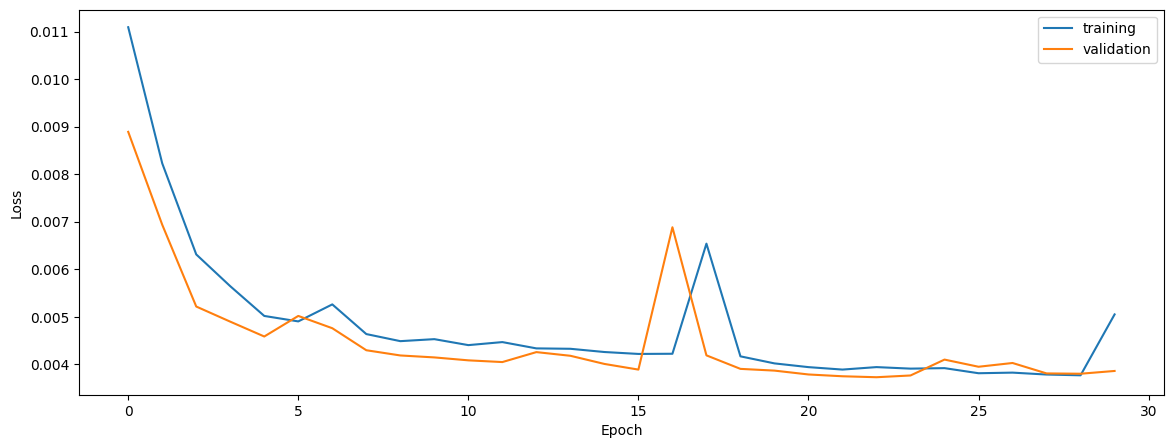

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7858966226744476
0.7771036933781669
0.7741077520744581


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7858966226744476
0.7771036933781669
0.7741077520744581


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7886867553298452
0.7743638989520372
0.7832254168426143


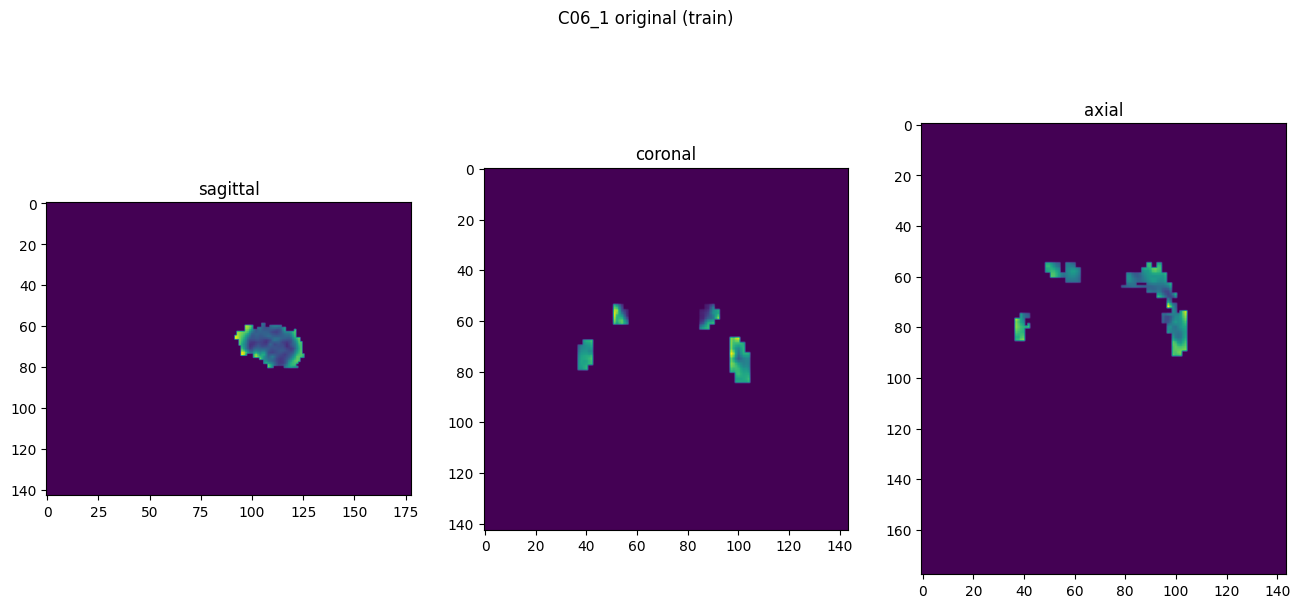

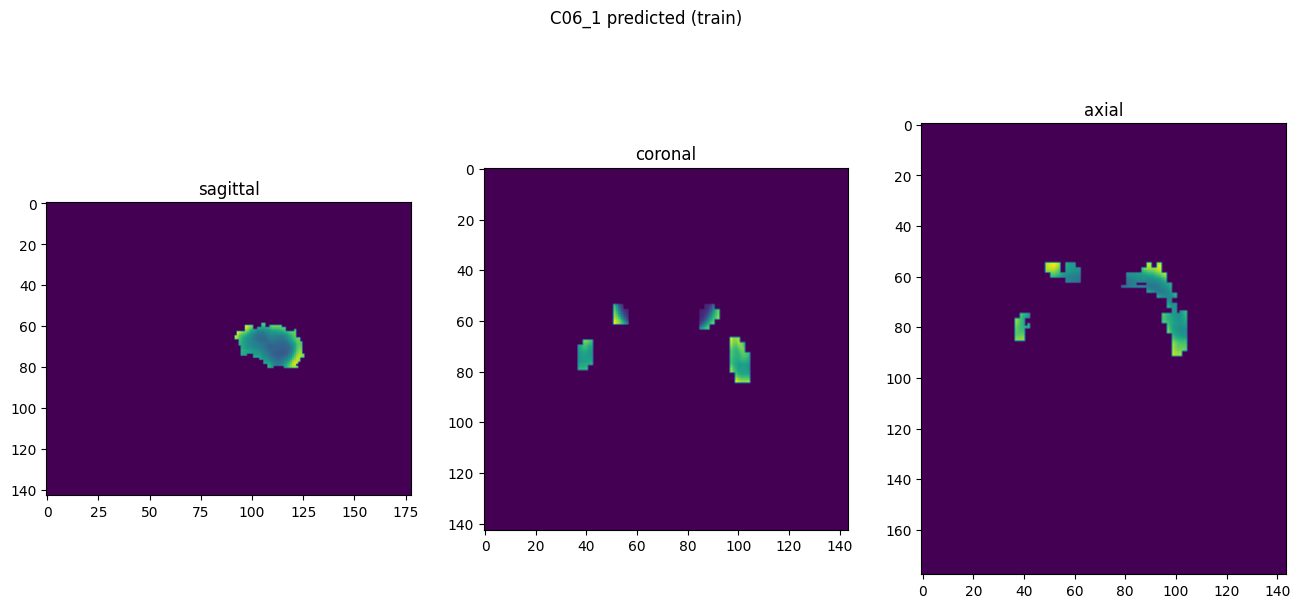

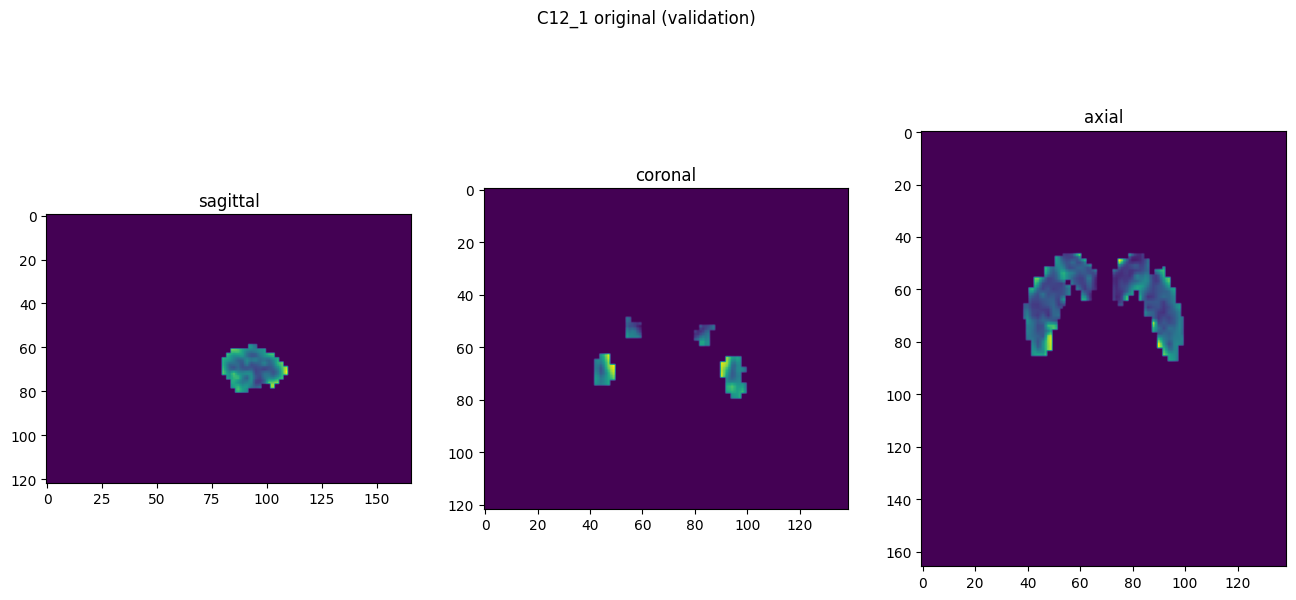

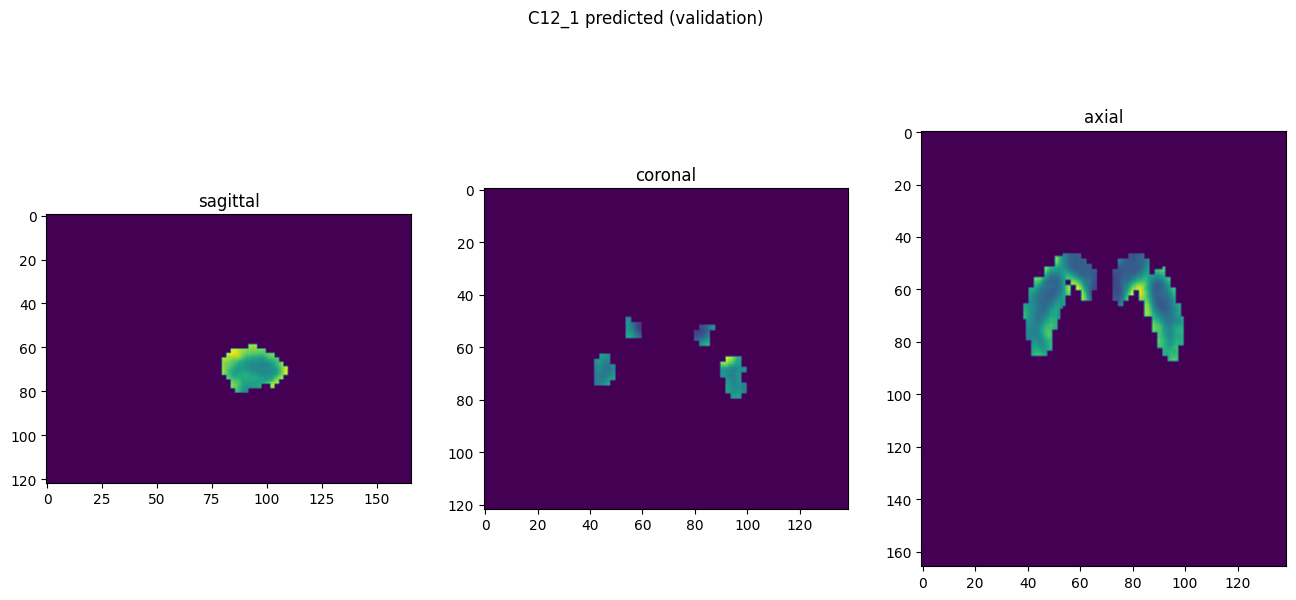

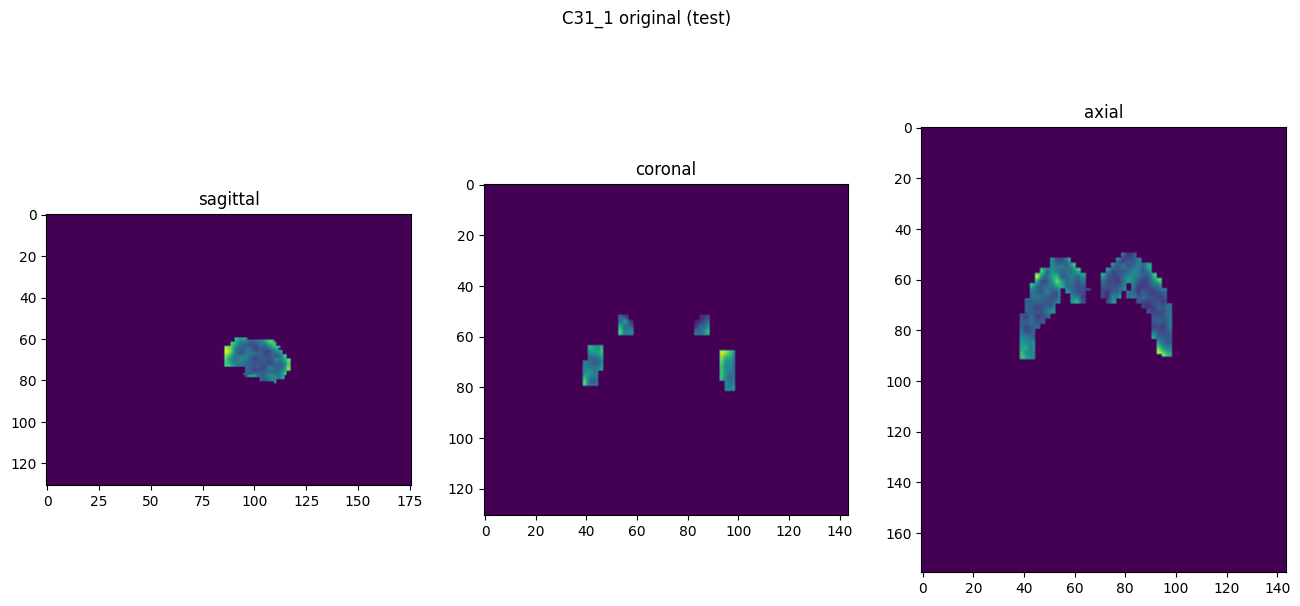

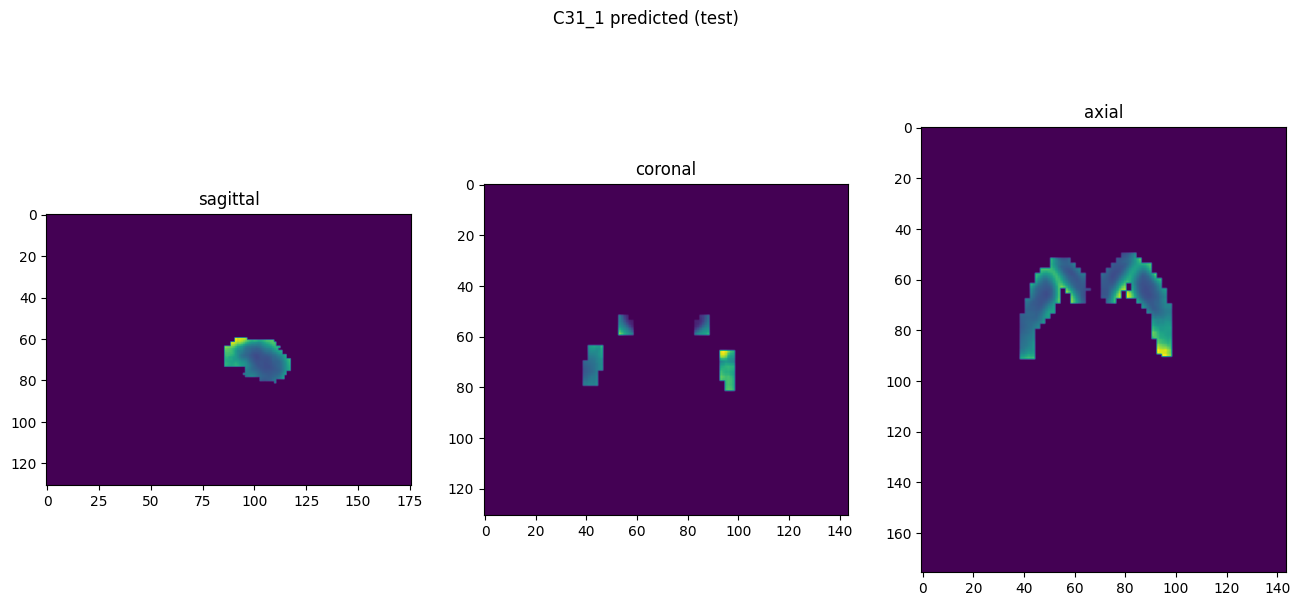

In [10]:
showResults(model, gen, threshold=None, background=False)